In [17]:
#!pip install tweet-preprocessor      

  Running setup.py bdist_wheel for tweet-preprocessor ... done
  Stored in directory: /Users/JackNelson/Library/Caches/pip/wheels/64/d9/5c/c72815d52f5770f229b909840516fd7a36e11bd57d4b8f28dd
Successfully built tweet-preprocessor


In [1]:
import pandas as pd
df = pd.read_csv('data/csv_daily/Bitcoin/20180305.csv',lineterminator='\n')
#print df.head(5)
print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71948 entries, 0 to 71947
Data columns (total 15 columns):
Unnamed: 0              71948 non-null int64
id                      71948 non-null int64
text                    71948 non-null object
created_at              71948 non-null object
retweet_count           71948 non-null int64
favorite_count          71948 non-null int64
source                  71948 non-null object
user_id                 71948 non-null int64
user_screen_name        71948 non-null object
user_name               71947 non-null object
user_created_at         71948 non-null object
user_description        52057 non-null object
user_followers_count    71948 non-null int64
user_friends_count      71948 non-null int64
user_location           41961 non-null object
dtypes: int64(7), object(8)
memory usage: 8.2+ MB
None


In [2]:
import pandas as pd
import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

class DailySentiment:
    def __init__(self):
        # instantiate tweet tokenizer from nltk.tokenize, set to remove handles and reduce repeating characters
        self._tweetProcessor = TweetTokenizer(strip_handles=False, reduce_len=True)
        # instantiate sentiment intensity analyzer from nltk.sentiment.vader
        self._vaderAnalyzer = SentimentIntensityAnalyzer()
    
    # external function to return average VADER polarity score
    def getDailySentiment(self, df, keyword):
        scores = self.getSentimentScores(df, keyword)
        
        avg_scores = {'neg': sum(score['neg'] for score in scores) / len(scores),
                      'neu': sum(score['neu'] for score in scores) / len(scores),
                      'pos': sum(score['pos'] for score in scores) / len(scores),
                      'compound': sum(score['compound'] for score in scores) / len(scores)}
        return avg_scores
    
    # external function to return a list of VADER polarity scores 
    def getSentimentScores(self, df, keyword):
        #df = self._filterTweets(df, keyword)
        df = self._removeNoninfluencers(df)
        
        list_of_tweets = df.text
        scores = []
        for tweet in list_of_tweets:
            tweet = self._cleanTweet(tweet)
            scores.append(self._vaderAnalyzer.polarity_scores(tweet))
        return scores        
    
    # internal crosscheck function to remove tweets without keyword (BUG FIX) 
    def _filterTweets(self, df, keyword):
        df_filtered = df[df.text.str.contains(keyword)]
        return df_filtered
        
    # internal function to remove tweets from users below a follower threshold    
    def _removeNoninfluencers(self, df, min_follower = 100):
        df_filtered = df[df.user_followers_count > min_follower]
        return df_filtered
    
    # internal text preprocessing function
    def _cleanTweet(self, tweet):
        # set preprocessor to remove links, mentions, and reserved words (FAV, RT, etc.)
        p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
        # clean tweet with preprocessor and remove hashtags
        tweet = p.clean(tweet.translate(None, "#?"))
        # tokenize tweet
        #tweet = self._tweetProcessor.tokenize(tweet)
        # ...to put in, further filter punctuation and reconstruct tweet
        return tweet    

/Users/JackNelson/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
import os
import re
    
class SentimentsPerDay:
    def __init__(self, crypto):
        # assign folder_name to class
        self.crypto = crypto
        # instantiate DailySentiment class
        self._dailySentiment = DailySentiment()
        
    # external function returning list of sentiment scores for each file in folder    
    def getSentimentsPerDay(self):
        _files = self.getFiles()
        
        daily_sentiments = []    
        for _file in _files:
            path = "data/csv_daily/" + self.crypto + "/" +_file
            df = pd.read_csv(path,lineterminator='\n')
            daily_sentiments.append(self._dailySentiment.getDailySentiment(df, self.crypto))
                
        return daily_sentiments
            
    # internal function extracting list of csv files in folder
    def getFiles(self):
        # construct folder path where files reside
        folder_name = "/data/csv_daily/"
        path = str(os.getcwd()) + folder_name + self.crypto
        # using regex expression to only take file_names (instead of full paths)
        reg = re.compile("\d{8}")
            
        # loop to generate list of all files in folder that fit naming convention
        _files = []
        for csv_path in os.listdir(path):
            if reg.search(csv_path):
                 _files.append(csv_path)
        return _files          

In [4]:
BitcoinDailyAnalyzer = SentimentsPerDay('Bitcoin')
BitcoinSentiments = BitcoinDailyAnalyzer.getSentimentsPerDay()
print BitcoinSentiments

[{'neg': 0.0393967494775947, 'neu': 0.8447992570234552, 'pos': 0.1142731831901553, 'compound': 0.17353790573485162}, {'neg': 0.03964720110573581, 'neu': 0.8500682446441017, 'pos': 0.10904236735007283, 'compound': 0.15622846694309334}, {'neg': 0.03735097416598087, 'neu': 0.8532178054804024, 'pos': 0.1066073934689718, 'compound': 0.15919919636206742}, {'neg': 0.07538703792606548, 'neu': 0.7961711633862218, 'pos': 0.1267188670187298, 'compound': 0.12716803008481478}, {'neg': 0.04707606255749647, 'neu': 0.8369510579577061, 'pos': 0.11520673413064011, 'compound': 0.1602497755289798}, {'neg': 0.042505679427850294, 'neu': 0.849585443836765, 'pos': 0.10690769877997525, 'compound': 0.14733253681110572}, {'neg': 0.04847995986828549, 'neu': 0.8437849608972879, 'pos': 0.10539419119160132, 'compound': 0.1334963186869737}, {'neg': 0.04116663181374561, 'neu': 0.8584393384916128, 'pos': 0.09934657744319347, 'compound': 0.13066999686323907}, {'neg': 0.03740925985932955, 'neu': 0.8617062691801851, 'pos'

In [5]:
ETHDailyAnalyzer = SentimentsPerDay('ETH')
ETHSentiments = ETHDailyAnalyzer.getSentimentsPerDay()
print ETHSentiments

[{'neg': 0.018531067086897828, 'neu': 0.8603886762719519, 'pos': 0.12097028365601079, 'compound': 0.2369396330481766}, {'neg': 0.014696297883563043, 'neu': 0.8469636711281255, 'pos': 0.13820186918968827, 'compound': 0.28987797356102313}, {'neg': 0.013949451236568907, 'neu': 0.8428102611357008, 'pos': 0.14286645385285804, 'compound': 0.2978536735063535}, {'neg': 0.014237259624574549, 'neu': 0.8465348090377315, 'pos': 0.13869388691363832, 'compound': 0.28275477310090397}, {'neg': 0.018613344189235406, 'neu': 0.8295216403839323, 'pos': 0.15132482002055925, 'compound': 0.30254334504628005}, {'neg': 0.00929735563950351, 'neu': 0.8446602806260162, 'pos': 0.14577792768483572, 'compound': 0.3279090933621181}, {'neg': 0.01706418039895924, 'neu': 0.8286973113616647, 'pos': 0.15337814397224603, 'compound': 0.3321795316565477}, {'neg': 0.016499752218047992, 'neu': 0.8170899688274395, 'pos': 0.16603160418829868, 'compound': 0.34961052194072667}, {'neg': 0.02084303451418153, 'neu': 0.825121862778554

In [6]:
RippleDailyAnalyzer = SentimentsPerDay('Ripple')
RippleSentiments = RippleDailyAnalyzer.getSentimentsPerDay()
print RippleSentiments

[{'neg': 0.024834301842935363, 'neu': 0.8430667441474328, 'pos': 0.10562925452432341, 'compound': 0.1945591316619632}, {'neg': 0.027358611273648522, 'neu': 0.847177316169312, 'pos': 0.10801605227228521, 'compound': 0.1794554612833978}, {'neg': 0.03104603938903728, 'neu': 0.8426702056282497, 'pos': 0.10957112128508205, 'compound': 0.17080934996251523}, {'neg': 0.041526999558109436, 'neu': 0.8269417587273801, 'pos': 0.1001255413168387, 'compound': 0.14185942112240194}, {'neg': 0.041842739378566696, 'neu': 0.84382133798353, 'pos': 0.10202980342422281, 'compound': 0.13580186535616234}, {'neg': 0.029736598279285206, 'neu': 0.8239334877564535, 'pos': 0.14103209794837995, 'compound': 0.23855463269358132}, {'neg': 0.02964543726235744, 'neu': 0.8047005703422034, 'pos': 0.1504581749049431, 'compound': 0.3134207224334604}, {'neg': 0.03120087002527736, 'neu': 0.8315574432230167, 'pos': 0.13361844296826653, 'compound': 0.2520913213019183}, {'neg': 0.03881289103712249, 'neu': 0.8405954314596397, 'po

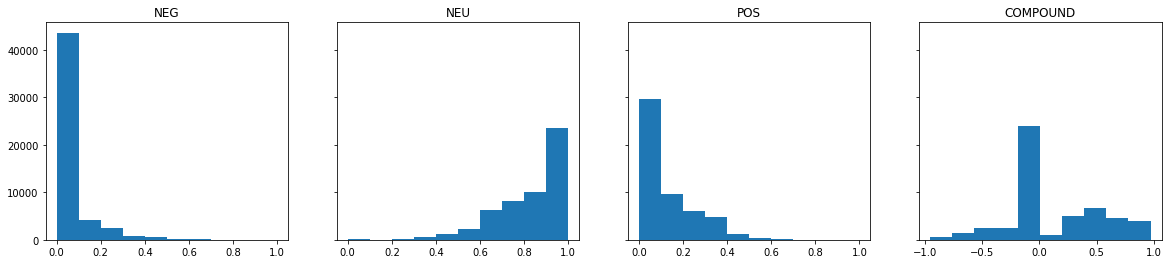

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.hist([score['neg'] for score in scores])
#plt.show()

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20,4))
#f.figsize(15,15)
ax1.hist([score['neg'] for score in scores])
ax1.set_title('NEG')
ax2.hist([score['neu'] for score in scores])
ax2.set_title('NEU')
ax3.hist([score['pos'] for score in scores])
ax3.set_title('POS')
ax4.hist([score['compound'] for score in scores])
ax4.set_title('COMPOUND')
plt.show()